# Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import time

Import data and take sample of 10,000 observations

In [2]:
# import data
# all_data = pd.read_csv('icml_face_data.csv')
all_data = pd.read_csv('../input/facial-expression-recognition-challenge/icml_face_data.csv/icml_face_data.csv')
# pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')
all_data = all_data.sample(n=10000, random_state=1)

accuracy = {}
params = {}

In [3]:
#all_data.head()

In [4]:
all_data.rename({' Usage': 'Usage', ' pixels': 'pixels'}, axis=1, inplace=True)

Create function to convert to numpy array and scale pixel values to [0,1]

In [5]:
def scale_pixels_to_arr(pixels):
    array = np.array(pixels.split(),'float64')/255
    return array

all_data['pixels_arr'] = all_data['pixels'].apply(scale_pixels_to_arr)

In [6]:
all_data.head()

,emotion,Usage,pixels,pixels_arr
35624,0,PrivateTest,122 107 68 76 101 125 141 144 143 159 161 123 ...,"[0.47843137254901963, 0.4196078431372549, 0.26..."
12788,3,Training,151 151 165 135 131 141 185 164 140 160 163 12...,"[0.592156862745098, 0.592156862745098, 0.64705..."
7821,3,Training,88 68 83 107 84 62 91 147 159 159 158 154 150 ...,"[0.34509803921568627, 0.26666666666666666, 0.3..."
31831,6,PublicTest,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 109 193 177 ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16799,3,Training,231 193 124 96 115 107 84 76 84 84 79 72 67 58...,"[0.9058823529411765, 0.7568627450980392, 0.486..."


In [7]:
all_data.loc[all_data['emotion'].isin([0,1,4]), 'emotion_group'] = 'Angry/Sad'
all_data.loc[all_data['emotion'].isin([2,5]), 'emotion_group'] = 'Fear/Surprise'
all_data.loc[all_data['emotion'] == 3, 'emotion_group'] = 'Happy'
all_data.loc[all_data['emotion'] == 6, 'emotion_group'] = 'Neutral'

In [8]:
all_data

,emotion,Usage,pixels,pixels_arr,emotion_group
35624,0,PrivateTest,122 107 68 76 101 125 141 144 143 159 161 123 ...,"[0.47843137254901963, 0.4196078431372549, 0.26...",Angry/Sad
12788,3,Training,151 151 165 135 131 141 185 164 140 160 163 12...,"[0.592156862745098, 0.592156862745098, 0.64705...",Happy
7821,3,Training,88 68 83 107 84 62 91 147 159 159 158 154 150 ...,"[0.34509803921568627, 0.26666666666666666, 0.3...",Happy
31831,6,PublicTest,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 109 193 177 ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Neutral
16799,3,Training,231 193 124 96 115 107 84 76 84 84 79 72 67 58...,"[0.9058823529411765, 0.7568627450980392, 0.486...",Happy
...,...,...,...,...,...
7198,6,Training,62 57 24 37 44 53 71 79 78 83 88 86 75 59 51 4...,"[0.24313725490196078, 0.2235294117647059, 0.09...",Neutral
14808,6,Training,255 253 247 244 239 223 183 109 45 20 32 102 1...,"[1.0, 0.9921568627450981, 0.9686274509803922, ...",Neutral
6494,4,Training,114 69 61 62 62 59 55 52 54 56 57 62 72 78 83 ...,"[0.4470588235294118, 0.27058823529411763, 0.23...",Angry/Sad
17024,0,Training,142 145 152 134 64 63 65 75 55 38 70 106 131 1...,"[0.5568627450980392, 0.5686274509803921, 0.596...",Angry/Sad


In [9]:
def image_reshape(data):
    image = np.reshape(data['pixels_arr'].to_list(),(data.shape[0],48,48,1))
    return image

X = image_reshape(all_data)
y = all_data['emotion']
y_group = all_data['emotion_group']

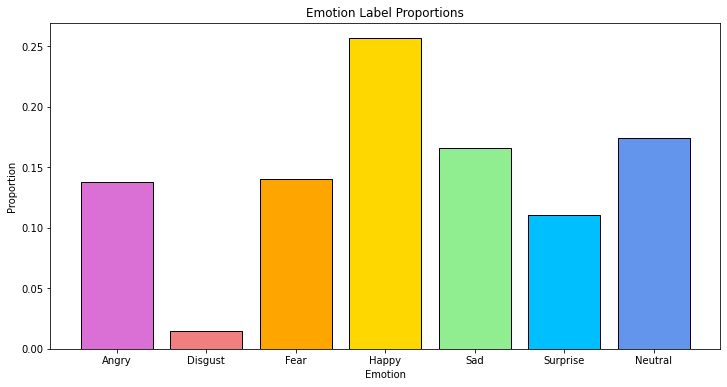

In [10]:
emotion_prop = (all_data.emotion.value_counts() / len(all_data)).to_frame().sort_index(ascending=True)

emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], color=palette, edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Emotion Label Proportions')
plt.show()

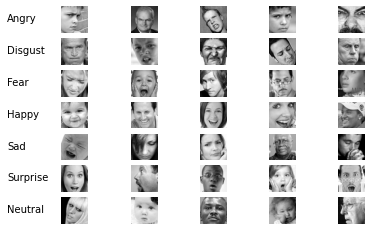

In [11]:
row = 0
for emotion in list(range(7)):

    all_emotion_images = all_data[all_data['emotion'] == emotion]
    for i in range(5):
        
        img = all_emotion_images.iloc[i,].pixels_arr.reshape(48,48)
        lab = emotions[emotion]
        
        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.axis('off')
    plt.text(-600, 27, s = str(lab), fontsize=10)
    row += 5

plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_data['pixels_arr'], y, test_size=0.2, random_state=12345)
print("Pixels as Single array")
print("Training data shape: ", X_train.shape)
print("Test data shape", X_test.shape)

Pixels as Single array
Training data shape:  (8000,)
Test data shape (2000,)


In [13]:
x_unraveled = pd.DataFrame(list(map(np.ravel, all_data['pixels_arr'])))
X_train_unrav, X_test_unrav, y_train_unrav, y_test_unrav = train_test_split(x_unraveled, y, test_size=0.2, random_state=12345)
print("Pixels as columns")
print("Training data shape: ", X_train_unrav.shape)
print("Test data shape", X_test_unrav.shape)


Pixels as columns
Training data shape:  (8000, 2304)
Test data shape (2000, 2304)


In [14]:
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X, y, test_size=0.2, random_state=12345)
print("Converted Images")
print("Training data shape: ", X_train_im.shape)
print("Test data shape", X_test_im.shape)

Converted Images
Training data shape:  (8000, 48, 48, 1)
Test data shape (2000, 48, 48, 1)


Using additional emotion groupings (`y_group`):

In [15]:
X_train, X_test, y_train_g, y_test_g = train_test_split(all_data['pixels_arr'], y_group, test_size=0.2, random_state=12345)
X_train_unrav, X_test_unrav, y_train_unrav_g, y_test_unrav_g = train_test_split(x_unraveled, y_group, test_size=0.2, random_state=12345)
X_train_im, X_test_im, y_train_im_g, y_test_im_g = train_test_split(X, y_group, test_size=0.2, random_state=12345)

## K Nearest Neighbors Model

In [16]:
knn = KNeighborsClassifier(algorithm='auto')
param_grid = dict(n_neighbors=list(range(1, 16)))
model_KNN = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy',verbose=1)

model_KNN.fit(X_train_unrav, y_train)
y_pred_KNN = model_KNN.predict(X_test_unrav)

print(model_KNN.best_params_)

accuracy['KNN'] = accuracy_score(y_pred_KNN, y_test)
params['KNN'] = model_KNN.best_params_
print(f"The model is {accuracy['KNN']*100:.2f}% accurate")

print('Classification Report:',classification_report(y_test,y_pred_KNN))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 57.6min finished


{'n_neighbors': 15}
The model is 28.15% accurate
Classification Report:               precision    recall  f1-score   support

           0       0.18      0.11      0.13       268
           1       0.00      0.00      0.00        27
           2       0.16      0.07      0.10       278
           3       0.32      0.60      0.42       503
           4       0.28      0.17      0.21       352
           5       0.43      0.19      0.26       234
           6       0.24      0.32      0.28       338

    accuracy                           0.28      2000
   macro avg       0.23      0.21      0.20      2000
weighted avg       0.27      0.28      0.25      2000



Additional groupings:

In [17]:
knn = KNeighborsClassifier(algorithm='auto')
param_grid = dict(n_neighbors=list(range(1, 16)))
model_KNN = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy',verbose=1)

model_KNN.fit(X_train_unrav, y_train_g)
y_pred_KNN = model_KNN.predict(X_test_unrav)

print(model_KNN.best_params_)

accuracy['KNN_group'] = accuracy_score(y_pred_KNN, y_test_g)
params['KNN_group'] = model_KNN.best_params_
print(f"The model is {accuracy['KNN_group']*100:.2f}% accurate")

print('Classification Report:',classification_report(y_test_g,y_pred_KNN))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 57.5min finished


{'n_neighbors': 2}
The model is 36.95% accurate
Classification Report:                precision    recall  f1-score   support

    Angry/Sad       0.37      0.54      0.44       647
Fear/Surprise       0.39      0.39      0.39       512
        Happy       0.36      0.30      0.33       503
      Neutral       0.30      0.12      0.17       338

     accuracy                           0.37      2000
    macro avg       0.36      0.34      0.33      2000
 weighted avg       0.36      0.37      0.35      2000



## SVM Model

In [18]:
# # param_grid = {'C':[1,10],'gamma':[0.001,0.1],'kernel':['rbf','poly']}
# param_grid = {'C':[0.01,0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly', 'linear']}
# svc = svm.SVC(probability=True)
# print("The training of the model is started, please wait for while as it may take few minutes to complete")

# model_SVM = GridSearchCV(svc,param_grid)

# start = time.time()
# model_SVM.fit(X_train_unrav,y_train)
# end = time.time()

# print(f"Train time {end-start}")

# print('The Model is trained well with the given images')
# print(model_SVM.best_params_)

# y_pred_SVM = model_SVM.predict(X_test_unrav)
# accuracy['SVM'] = accuracy_score(y_pred_SVM, y_test)
# params['SVM'] = model_SVM.best_params_

# print(f"The model is {accuracy['SVM']*100:.2f}% accurate")

Additional groupings:

In [19]:
# # param_grid = {'C':[1,10],'gamma':[0.001,0.1],'kernel':['rbf','poly']}
# param_grid = {'C':[0.01,0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly', 'linear']}
# svc = svm.SVC(probability=True)
# print("The training of the model is started, please wait for while as it may take few minutes to complete")

# model_SVM = GridSearchCV(svc,param_grid)

# start = time.time()
# model_SVM.fit(X_train_unrav,y_train_g)
# end = time.time()

# print(f"Train time {end-start}")

# print('The Model is trained well with the given images')
# print(model_SVM.best_params_)

# y_pred_SVM = model_SVM.predict(X_test_unrav)
# accuracy['SVM_group'] = accuracy_score(y_pred_SVM, y_test_g)
# params['SVM_group'] = model_SVM.best_params_

# print(f"The model is {accuracy['SVM_group']*100:.2f}% accurate")

## Bernoulli Naive Bayes Model

In [20]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

bnb = BernoulliNB(binarize=0.1)
model_BNB = GridSearchCV(bnb, alphas, scoring='accuracy')
model_BNB.fit(X_train_unrav, y_train) 

y_pred_BNB = model_BNB.predict(X_test_unrav) 
accuracy['BNB'] = accuracy_score(y_pred_BNB,y_test)
params['BNB'] = model_BNB.best_params_

print(f"The model is {accuracy['BNB']*100:.2f}% accurate")

print('Classification Report:',classification_report(y_test,y_pred_BNB))

The model is 17.20% accurate
Classification Report:               precision    recall  f1-score   support

           0       0.21      0.08      0.11       268
           1       0.01      0.15      0.03        27
           2       0.15      0.05      0.07       278
           3       0.29      0.05      0.09       503
           4       0.26      0.23      0.24       352
           5       0.16      0.64      0.26       234
           6       0.24      0.14      0.18       338

    accuracy                           0.17      2000
   macro avg       0.19      0.19      0.14      2000
weighted avg       0.23      0.17      0.15      2000



Additional groupings:

In [21]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

bnb = BernoulliNB(binarize=0.1)
model_BNB = GridSearchCV(bnb, alphas, scoring='accuracy')
model_BNB.fit(X_train_unrav, y_train_g) 

y_pred_BNB = model_BNB.predict(X_test_unrav) 
accuracy['BNB_group'] = accuracy_score(y_pred_BNB,y_test_g)
params['BNB_group'] = model_BNB.best_params_

print(f"The model is {accuracy['BNB_group']*100:.2f}% accurate")

print('Classification Report:',classification_report(y_test_g,y_pred_BNB))

The model is 29.65% accurate
Classification Report:                precision    recall  f1-score   support

    Angry/Sad       0.41      0.20      0.27       647
Fear/Surprise       0.29      0.67      0.40       512
        Happy       0.31      0.10      0.15       503
      Neutral       0.22      0.21      0.22       338

     accuracy                           0.30      2000
    macro avg       0.31      0.29      0.26      2000
 weighted avg       0.32      0.30      0.26      2000



In [22]:
# alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

# gs_nb = GridSearchCV(BernoulliNB(binarize = 0.1), alphas, cv = 5, scoring='accuracy').fit(X_train_unrav, y_train)
# for i in range(0,len(alphas['alpha'])):
#     print('Alpha:',gs_nb.cv_results_['param_alpha'][i], 'Score:',round(gs_nb.cv_results_['mean_test_score'][i],3))
# print('Best alpha value:',gs_nb.best_params_)

# y_pred_BNB = gs_nb.predict(X_test_unrav)

# print(f'The model is {accuracy_score(y_pred_BNB,y_test)}% accurate')

## Multinomial Naive Bayes Model

In [23]:
# GRID SEARCH
def trinarize(data, lower, upper):
        trinarized_data = np.zeros(data.shape)
        trinarized_data[(data <= lower)] = 0
        trinarized_data[(data > lower)] = 1
        trinarized_data[(data >= upper)] = 2
        return trinarized_data

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

mnb = MultinomialNB()
model_MNB = GridSearchCV(mnb, alphas, scoring='accuracy')
model_MNB.fit(trinarize(X_train_unrav,0.25,0.75), y_train)
y_pred_MNB = model_MNB.predict(trinarize(X_test_unrav,0.25,0.75))
accuracy['MNB'] = accuracy_score(y_pred_MNB,y_test)
params['MNB'] = model_MNB.best_params_

print(f"The Naive Bayes model is {accuracy['MNB']*100:.2f}% accurate")

print('Classification Report:',classification_report(y_test,y_pred_MNB))

The Naive Bayes model is 22.65% accurate
Classification Report:               precision    recall  f1-score   support

           0       0.18      0.16      0.17       268
           1       0.02      0.11      0.03        27
           2       0.13      0.21      0.16       278
           3       0.35      0.26      0.30       503
           4       0.23      0.07      0.11       352
           5       0.31      0.28      0.29       234
           6       0.29      0.38      0.33       338

    accuracy                           0.23      2000
   macro avg       0.21      0.21      0.20      2000
weighted avg       0.26      0.23      0.23      2000



Additional groupings:

In [24]:
# GRID SEARCH
def trinarize(data, lower, upper):
        trinarized_data = np.zeros(data.shape)
        trinarized_data[(data <= lower)] = 0
        trinarized_data[(data > lower)] = 1
        trinarized_data[(data >= upper)] = 2
        return trinarized_data

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

mnb = MultinomialNB()
model_MNB = GridSearchCV(mnb, alphas, scoring='accuracy')
model_MNB.fit(trinarize(X_train_unrav,0.25,0.75), y_train_g)
y_pred_MNB = model_MNB.predict(trinarize(X_test_unrav,0.25,0.75))
accuracy['MNB_group'] = accuracy_score(y_pred_MNB,y_test_g)
params['MNB_group'] = model_MNB.best_params_

print(f"The Naive Bayes model is {accuracy['MNB_group']*100:.2f}% accurate")

print('Classification Report:',classification_report(y_test_g,y_pred_MNB))

The Naive Bayes model is 33.70% accurate
Classification Report:                precision    recall  f1-score   support

    Angry/Sad       0.40      0.27      0.33       647
Fear/Surprise       0.34      0.39      0.36       512
        Happy       0.35      0.31      0.33       503
      Neutral       0.27      0.42      0.33       338

     accuracy                           0.34      2000
    macro avg       0.34      0.35      0.34      2000
 weighted avg       0.35      0.34      0.34      2000



## Gaussian Naive Naive Bayes Model

In [25]:
#GRID SEARCH
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb2 = GaussianNB()
model_GNB2 = GridSearchCV(gnb2, param_grid, scoring='accuracy')
model_GNB2.fit(X_train_unrav, y_train)
y_pred_GNB2 = model_GNB2.predict(X_test_unrav)
accuracy['GNB'] = accuracy_score(y_pred_GNB2,y_test)
params['GNB'] = model_GNB2.best_params_

print(f"Gaussian Naive Bayes model with var_smoothing set to 0.1 had accuracy {accuracy['GNB']*100:.2f}%")

print('Classification Report:',classification_report(y_test,y_pred_GNB2))

Gaussian Naive Bayes model with var_smoothing set to 0.1 had accuracy 21.75%
Classification Report:               precision    recall  f1-score   support

           0       0.14      0.04      0.06       268
           1       0.01      0.15      0.02        27
           2       0.15      0.04      0.06       278
           3       0.41      0.16      0.23       503
           4       0.26      0.40      0.31       352
           5       0.24      0.59      0.34       234
           6       0.26      0.15      0.19       338

    accuracy                           0.22      2000
   macro avg       0.21      0.22      0.17      2000
weighted avg       0.26      0.22      0.20      2000



Additional groupings:

In [26]:
#GRID SEARCH
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb2 = GaussianNB()
model_GNB2 = GridSearchCV(gnb2, param_grid, scoring='accuracy')
model_GNB2.fit(X_train_unrav, y_train_g)
y_pred_GNB2 = model_GNB2.predict(X_test_unrav)
accuracy['GNB_group'] = accuracy_score(y_pred_GNB2,y_test_g)
params['GNB_group'] = model_GNB2.best_params_

print(f"Gaussian Naive Bayes model with var_smoothing set to 0.1 had accuracy {accuracy['GNB_group']*100:.2f}%")

print('Classification Report:',classification_report(y_test_g,y_pred_GNB2))

Gaussian Naive Bayes model with var_smoothing set to 0.1 had accuracy 36.15%
Classification Report:                precision    recall  f1-score   support

    Angry/Sad       0.44      0.32      0.37       647
Fear/Surprise       0.37      0.60      0.46       512
        Happy       0.36      0.26      0.30       503
      Neutral       0.24      0.25      0.24       338

     accuracy                           0.36      2000
    macro avg       0.35      0.35      0.34      2000
 weighted avg       0.37      0.36      0.35      2000



## CNN Model 

In [27]:
# scaler = StandardScaler()
# scaler.fit(X_train_unrav)
# X_train_unrav = scaler.transform(X_train_unrav)
# X_test_unrav = scaler.transform(X_test_unrav)
# param_grid = {'alpha': 10.0 ** -np.arange(1, 7),
#              'solver': ['lbfgs', 'adam'],
#              'hidden_layer_sizes': [250, 100, 50, 25, 5]}
# clf = GridSearchCV(MLPClassifier(random_state=12345), param_grid)
# start = time.time()
# clf.fit(X_train_unrav, y_train_unrav)
# end = time.time()
# print(f"Train time: {start-end}")

In [28]:
# # From https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
# print("Best parameters set found on training set:")
# print()
# print(clf.best_params_)
# print()
# print("Grid scores on training set:")
# print()
# means = clf.cv_results_["mean_test_score"]
# stds = clf.cv_results_["std_test_score"]
# for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# print()

In [29]:
# print("Detailed classification report for optimal parameters:")
# print()
# print("The model is trained on the full training set.")
# print("The scores are computed on the full test set.")
# print()
# y_true, y_pred = y_test_unrav, clf.predict(X_test_unrav)
# print(classification_report(y_true, y_pred))
# print()

In [30]:
# params['CLF'] = clf.best_params_

In [31]:
accuracy_df = pd.DataFrame(list(accuracy.items()))
params_df = pd.DataFrame(list(params.items()))

accuracy_df.to_csv('accuracy_df.csv', index=False)
params_df.to_csv('params_df.csv', index=False)
